In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns


In [2]:
features = pd.read_csv("features.csv")
brand = pd.read_csv("Brand_Mapping.csv")

df = features[['Date','Temperature','Fuel_Price','CPI','Unemployment','IsHoliday']].copy()

df['Date'] = pd.to_datetime(df['Date'])

selected_categories = ['RTD Tea/Coffee',
                     'Energy Drinks',
                     'Sports Drinks',
                     'Dairy-based Drinks',
                     'Beverage Mixes',
                      'Dietary Supplements']

selected_brands = ['THE COCA-COLA CO.',
                 'PEPSICO INC.',
                 'HEINEKEN N.V.',
                 'SUNTORY HOLDINGS LTD.',
                 'DIAGEO PLC']

selected_regions = ['Midwest',
                   'West',
                   'South',
                   'Northeast']


df['Brands'] = [selected_brands] * df.shape[0]
df['Categories'] = [selected_categories] * df.shape[0]
df['Region'] = [selected_regions] * df.shape[0]

df = df.explode('Brands')
df = df.explode('Categories')
df = df.explode('Region')

df.drop_duplicates(subset=['Date','Brands','Categories','Region'],inplace=True)


In [3]:
# 1235,12313,1,7811
seed = 7811
def strong_trend_and_seasonality(nsample):
    ## simulate a simple sinusoidal function
    random.seed(seed)
    x1 = np.linspace(1, 100, nsample)
    
    slope = random.uniform(.035, 0.045)
    intercept = random.uniform(1.8, 2.2)
    
    trend = intercept + slope*x1

    # Seasonal
    seasonal = np.sin(random.uniform(.35, .45)*x1)

    #noise 
    sigma = 0.2
    noise = sigma * np.random.normal(size=nsample)

    y =((trend+ seasonal + noise)*100).astype(int)
    return y

def no_pattern(lower, upper, nsample):
    random.seed(seed)
    return np.random.randint(lower,upper,nsample)

def correlated_discounts(nsample, discount):
    ## simulate a simple sinusoidal function
    random.seed(seed)
    x1 = np.linspace(1, 100, nsample)
    
    slope = random.uniform(.035, 0.045)
    intercept = random.uniform(1.8, 2.2)
    
    trend = intercept + slope*x1

    # Seasonal
    seasonal = np.sin(random.uniform(.35, .45)*x1)

    #noise 
    sigma = 0.2
    noise = sigma * np.random.normal(size=nsample)

    y =((trend+ seasonal + 4*discount+noise)*100).astype(int)
    return y

def lumpy_demand(df): 
    random.seed(seed)
    col_name = "Weekly Sales"
    nan_percent = {col_name:0.025}
    
    for i, row_value in df[col_name].iteritems():
        if random.random() <= nan_percent[col_name]:
            df[col_name][i] = np.nan
    df[col_name] = df[col_name].fillna(0)
    return df[col_name]

def lagged_correlation(nsample,fuel,cpi,unemployment):
    ## simulate a simple sinusoidal function
    random.seed(seed)
    x1 = np.linspace(1, 100, nsample)
    
    slope = random.uniform(.035, 0.045)
    intercept = random.uniform(1.8, 2.2)
    
    trend = intercept + slope*x1

    # Seasonal
    seasonal = np.sin(random.uniform(.35, .45)*x1)

    #noise 
    sigma = 0.2
    noise = sigma * np.random.normal(size=nsample)
    
    y =((trend+ seasonal + noise+fuel/fuel.sum()+cpi/cpi.sum()+unemployment/unemployment.sum())*100)

    return y
    
    
    



In [4]:
sales_df = pd.DataFrame()

total_iter = len(selected_categories)
count = 0

for cat in selected_categories:
            
    count = count + 1

    print(f"\rRunning Iteration {count}/{total_iter}...",end='')
    
#   strong trend and seasonality
    if(cat == 'RTD Tea/Coffee'):
        
        sub = df[df['Categories'] == cat].copy()            
        sub = sub.sort_values(by=['Date'],ascending=True)
        sub['Discounts'] = np.random.uniform(0.05, 0.40,sub.shape[0])
        
        sub["Weekly Sales"] = strong_trend_and_seasonality(sub.shape[0]) 
        
        replacement_mapping_dict={'THE COCA-COLA CO.':'COCOA_1',
                          'PEPSICO INC.':'COCOA_2',
                          'HEINEKEN N.V.':'COCOA_3',
                          'SUNTORY HOLDINGS LTD.':'COCOA_4',
                          'DIAGEO PLC':'COCOA_5'}

        sub["Brands"].replace(replacement_mapping_dict, inplace=True)

        
        if sales_df.shape[0]:
            sales_df = pd.concat([sales_df,sub],axis=0,ignore_index=True,sort=False)
        else:
            sales_df = sub
#   Intermittent Demand
    elif(cat == 'Energy Drinks'):
        
        sub = df[df['Categories'] == cat].copy()            
        sub = sub.sort_values(by=['Date'],ascending=True)
        sub['Discounts'] = np.random.uniform(0.05, 0.40,sub.shape[0])

        sub["Weekly Sales"] = no_pattern(random.randint(250,270),random.randint(300,310),sub.shape[0])
        
        sub["Weekly Sales"] = lumpy_demand(sub)
        
        replacement_mapping_dict={'THE COCA-COLA CO.':'FIZZY_1',
                          'PEPSICO INC.':'FIZZY_2',
                          'HEINEKEN N.V.':'FIZZY_3',
                          'SUNTORY HOLDINGS LTD.':'FIZZY_4',
                          'DIAGEO PLC':'FIZZY_5'}

        sub["Brands"].replace(replacement_mapping_dict, inplace=True)

        
        if sales_df.shape[0]:
            sales_df = pd.concat([sales_df,sub],axis=0,ignore_index=True,sort=False)
        else:
            sales_df = sub

#   Discounts correlated
    elif(cat == 'Sports Drinks'):
        
        sub = df[df['Categories'] == cat].copy()            
        sub = sub.sort_values(by=['Date'],ascending=True)
        
        sub['Discounts'] = np.random.uniform(0.05, 0.40,sub.shape[0])
        sub["Weekly Sales"] = correlated_discounts(sub.shape[0],sub['Discounts'])
        
        replacement_mapping_dict={'THE COCA-COLA CO.':'COLA_1',
                          'PEPSICO INC.':'COLA_2',
                          'HEINEKEN N.V.':'COLA_3',
                          'SUNTORY HOLDINGS LTD.':'COLA_4',
                          'DIAGEO PLC':'COLA_5'}

        sub["Brands"].replace(replacement_mapping_dict, inplace=True)        
        
        if sales_df.shape[0]:
            sales_df = pd.concat([sales_df,sub],axis=0,ignore_index=True,sort=False)
        else:
            sales_df = sub
            
#   New category 
#   MILK_5 is the new product here
    elif(cat == 'Dairy-based Drinks'):
        
        sub = df[df['Categories'] == cat].copy()            
        sub = sub.sort_values(by=['Date'],ascending=True)
        
        sub['Discounts'] = np.random.uniform(0.05, 0.40,sub.shape[0])
        
        sub["Weekly Sales"] = strong_trend_and_seasonality(sub.shape[0])
        
#         sub['Weekly Sales'] = sub.apply(lambda x: np.nan if x['Brands'] == 'DIAGEO PLC' else x['Weekly Sales'], axis = 1)
        
        replacement_mapping_dict={'THE COCA-COLA CO.':'MILK_1',
                          'PEPSICO INC.':'MILK_2',
                          'HEINEKEN N.V.':'MILK_3',
                          'SUNTORY HOLDINGS LTD.':'MILK_4',
                          'DIAGEO PLC':'MILK_5'}
        
        sub["Brands"].replace(replacement_mapping_dict, inplace=True) 
        

        if sales_df.shape[0]:
            sales_df = pd.concat([sales_df,sub],axis=0,ignore_index=True,sort=False)
        else:
            sales_df = sub
            
#   Lumpy demand        
    elif(cat == 'Beverage Mixes'):
        
        sub = df[df['Categories'] == cat].copy()            
        sub = sub.sort_values(by=['Date'],ascending=True)
        
        sub['Discounts'] = np.random.uniform(0.05, 0.40,sub.shape[0])
        
        sub["Weekly Sales"] = no_pattern(random.randint(20,60),random.randint(300,310),sub.shape[0])
        
        sub["Weekly Sales"] = lumpy_demand(sub)
        
        replacement_mapping_dict={'THE COCA-COLA CO.':'JUICES_1',
                          'PEPSICO INC.':'JUICES_2',
                          'HEINEKEN N.V.':'JUICES_3',
                          'SUNTORY HOLDINGS LTD.':'JUICES_4',
                          'DIAGEO PLC':'JUICES_5'}
        
        sub["Brands"].replace(replacement_mapping_dict, inplace=True)        

        
        if sales_df.shape[0]:
            sales_df = pd.concat([sales_df,sub],axis=0,ignore_index=True,sort=False)
        else:
            sales_df = sub

#  Lagged Correlation Index
    
    elif(cat == 'Dietary Supplements'):
        
        sub = df[df['Categories'] == cat].copy()            
        sub = sub.sort_values(by=['Date'],ascending=True)
        
        sub['Discounts'] = np.random.uniform(0.05, 0.40,sub.shape[0])
        
        sub['Fuel_Price'] = sub['Fuel_Price'].shift(4) 
        sub['CPI'] = sub['CPI'].shift(4)
        sub['Unemployment'] = sub['Unemployment'].shift(4)
        
        sub["Weekly Sales"] = lagged_correlation(sub.shape[0],sub['Fuel_Price'],sub['CPI'],sub['Unemployment'])
        
        replacement_mapping_dict={'THE COCA-COLA CO.':'PROTEIN_1',
                          'PEPSICO INC.':'PROTEIN_2',
                          'HEINEKEN N.V.':'PROTEIN_3',
                          'SUNTORY HOLDINGS LTD.':'PROTEIN_4',
                          'DIAGEO PLC':'PROTEIN_5'}
        
        sub["Brands"].replace(replacement_mapping_dict, inplace=True)        

        
        
        if sales_df.shape[0]:
            sales_df = pd.concat([sales_df,sub],axis=0,ignore_index=True,sort=False)
        else:
            sales_df = sub

    
    else:
        print('xyz')
            
            
                    
                              

Running Iteration 3/6...

<ipython-input-3-bcea6955f39d>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_name][i] = np.nan
C:\Users\u351202\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Running Iteration 6/6...

In [5]:
# Making SKU's column
sales_df['SKU'] = sales_df['Brands'] + sales_df['Region']
sales_df['SKU'] = pd.factorize(sales_df['SKU'])[0]+1
sales_df['SKU'] = 'SKU_' + sales_df['SKU'].astype(str)

# Imputing Nan Values
sales_df['Fuel_Price'] = sales_df['Fuel_Price'].fillna(sales_df['Fuel_Price'].mean())
sales_df['CPI'] = sales_df['CPI'].fillna(sales_df['CPI'].mean())
sales_df['Unemployment'] = sales_df['Unemployment'].fillna(sales_df['Unemployment'].mean())

# Creating new product scenario having sales of last 6 months.....
weeks = 4*6
x_62 = sales_df[sales_df['SKU']=='SKU_62'][:-weeks].index.to_list()
x_63 = sales_df[sales_df['SKU']=='SKU_63'][:-weeks].index.to_list()
x_64 = sales_df[sales_df['SKU']=='SKU_64'][:-weeks].index.to_list()
x_65 = sales_df[sales_df['SKU']=='SKU_65'][:-weeks].index.to_list()

combined_list = x_62+x_63+x_64+x_65

sales_df.drop(sales_df.index[combined_list],inplace = True)

sales_df.dropna(inplace = True)

Text(0.5, 1.0, 'strong_trend_and_seasonality Weekly Sales Dairy-based Drinks MILK_1 South')

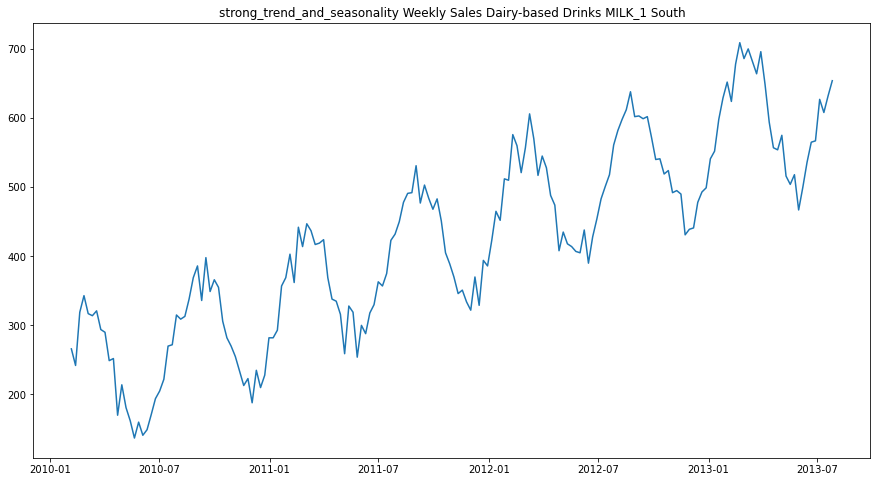

In [8]:
cat = 'Dairy-based Drinks'
comp = 'MILK_1'
reg= "South"


sub = sales_df[sales_df['Categories'] == cat].copy()
sub = sub[sub['Brands'] == comp]
sub = sub[sub['Region'] == reg]
            

plt.figure(figsize=(15,8))
plt.plot(sub["Date"], sub["Weekly Sales"])
plt.title(f"strong_trend_and_seasonality Weekly Sales {cat} {comp} {reg}")

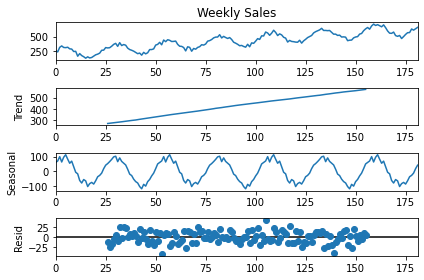

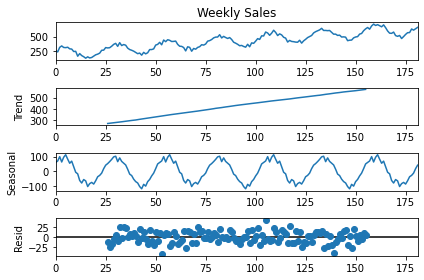

In [9]:
sub.reset_index(drop = True, inplace = True)
results = seasonal_decompose(sub['Weekly Sales'],model='additive', period=52)
results.plot()

C:\Users\u351202\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Intermittent Demand Weekly Sales Energy Drinks FIZZY_1 South')

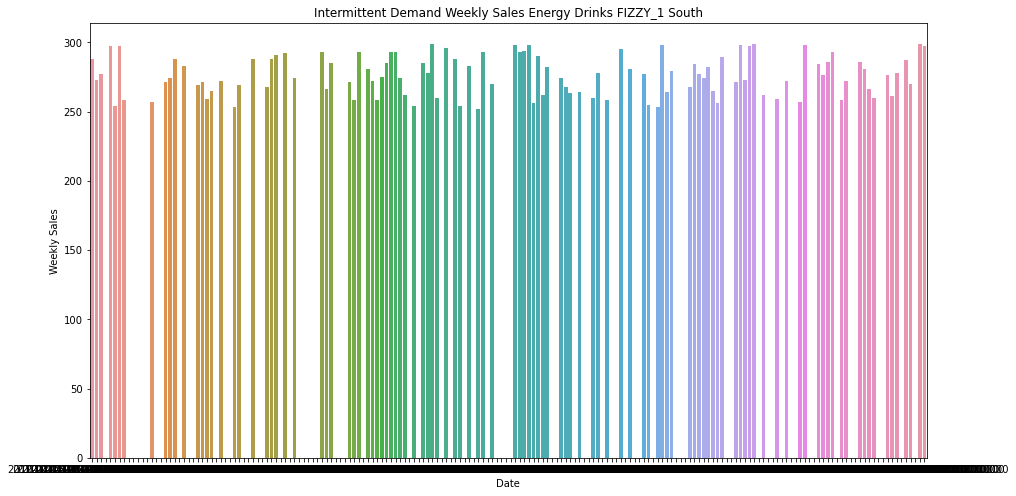

In [10]:
cat = 'Energy Drinks'
comp = 'FIZZY_1'
reg= "South"


sub = sales_df[sales_df['Categories'] == cat].copy()
sub = sub[sub['Brands'] == comp]
sub = sub[sub['Region'] == reg]
            

plt.figure(figsize=(15,8))
sns.barplot(sub["Date"], sub["Weekly Sales"])
plt.title(f"Intermittent Demand Weekly Sales {cat} {comp} {reg}")

Text(0.5, 1.0, 'Discounts correlated Weekly Sales Sports Drinks COLA_1 South')

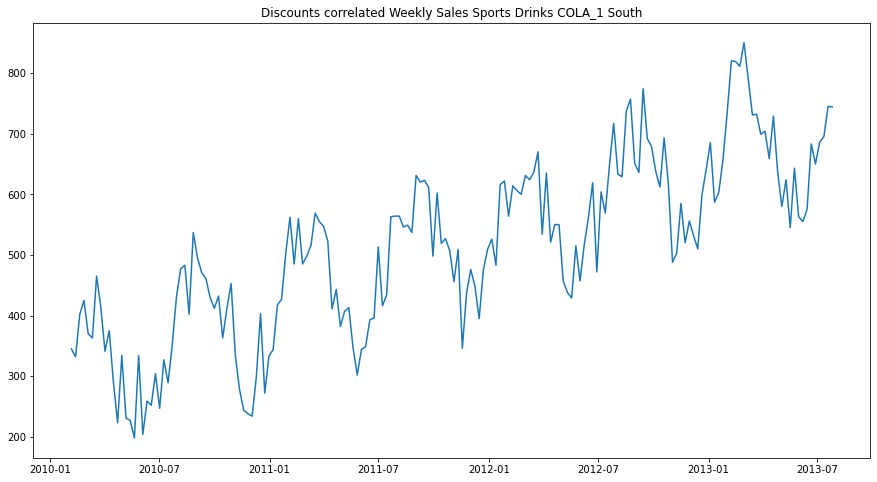

In [11]:
cat = 'Sports Drinks'
comp = 'COLA_1'
reg= "South"


sub = sales_df[sales_df['Categories'] == cat].copy()
sub = sub[sub['Brands'] == comp]
sub = sub[sub['Region'] == reg]
            

plt.figure(figsize=(15,8))
plt.plot(sub["Date"], sub["Weekly Sales"])
plt.title(f"Discounts correlated Weekly Sales {cat} {comp} {reg}")

C:\Users\u351202\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Lumpy Weekly Sales Beverage Mixes JUICES_1 Midwest')

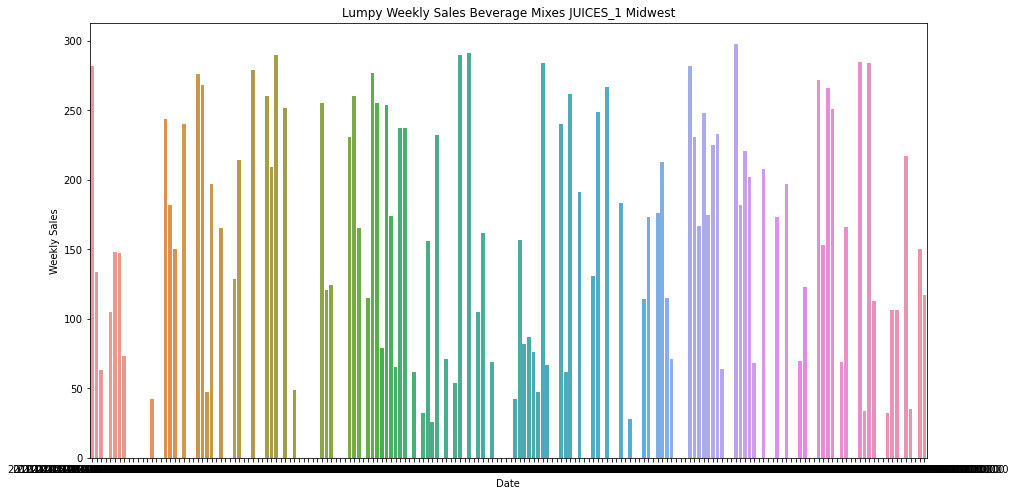

In [15]:
cat = 'Beverage Mixes'
comp = 'JUICES_1'
reg= "Midwest"


sub = sales_df[sales_df['Categories'] == cat].copy()
sub = sub[sub['Brands'] == comp]
sub = sub[sub['Region'] == reg]
            

plt.figure(figsize=(15,8))
sns.barplot(sub["Date"], sub["Weekly Sales"])
plt.title(f"Lumpy Weekly Sales {cat} {comp} {reg}")

In [17]:
x = (sub['Weekly Sales']==0).sum()
y = len(sub['Weekly Sales'])
x/y

0.3956043956043956

Text(0.5, 1.0, 'Lagged Correlation Index Weekly Sales Dietary Supplements PROTEIN_1 Midwest')

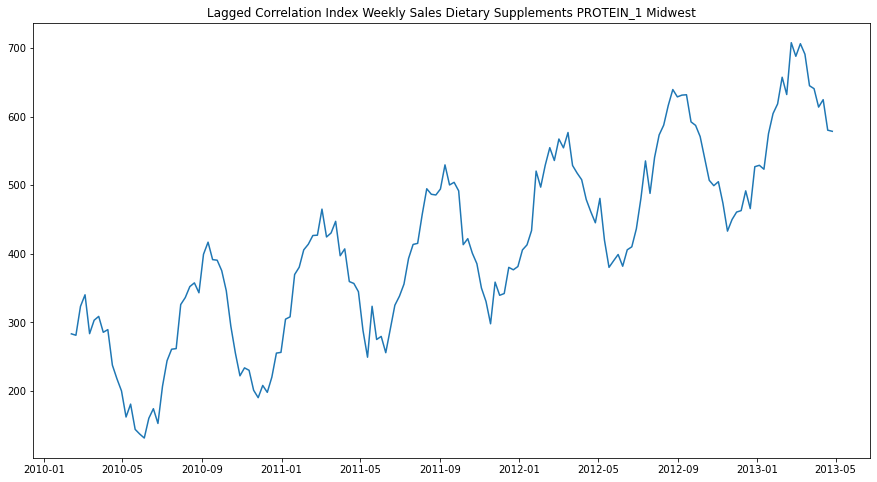

In [18]:
cat = 'Dietary Supplements'
comp = 'PROTEIN_1'
reg= "Midwest"


sub = sales_df[sales_df['Categories'] == cat].copy()
sub = sub[sub['Brands'] == comp]
sub = sub[sub['Region'] == reg]
            

plt.figure(figsize=(15,8))
plt.plot(sub["Date"], sub["Weekly Sales"])
plt.title(f"Lagged Correlation Index Weekly Sales {cat} {comp} {reg}")

In [19]:
cols = ['Date','Brands', 'Categories', 'Region','SKU','IsHoliday',
        'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Discounts','Weekly Sales']

In [20]:
sales_df[cols].to_csv("Supply_Chain_train_dataset.csv",index=False)

In [21]:
sales_df[cols]

,Date,Brands,Categories,Region,SKU,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Discounts,Weekly Sales
0,2010-02-05,COCOA_1,RTD Tea/Coffee,Midwest,SKU_1,False,42.31,2.572,211.096358,8.106,0.364745,299.000000
1,2010-02-05,COCOA_5,RTD Tea/Coffee,Northeast,SKU_2,False,42.31,2.572,211.096358,8.106,0.137534,236.000000
2,2010-02-05,COCOA_5,RTD Tea/Coffee,South,SKU_3,False,42.31,2.572,211.096358,8.106,0.367883,259.000000
3,2010-02-05,COCOA_5,RTD Tea/Coffee,West,SKU_4,False,42.31,2.572,211.096358,8.106,0.114149,246.000000
4,2010-02-05,COCOA_5,RTD Tea/Coffee,Midwest,SKU_5,False,42.31,2.572,211.096358,8.106,0.259252,257.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
21579,2013-04-26,PROTEIN_2,Dietary Supplements,Midwest,SKU_116,False,59.23,3.417,225.170160,6.314,0.237495,580.584070
21580,2013-05-03,PROTEIN_3,Dietary Supplements,South,SKU_110,False,66.66,3.417,225.170160,6.314,0.190037,575.082891
21581,2013-05-03,PROTEIN_5,Dietary Supplements,South,SKU_103,False,66.66,3.417,225.170160,6.314,0.346435,541.453670
21582,2013-05-03,PROTEIN_5,Dietary Supplements,West,SKU_104,False,66.66,3.417,225.170160,6.314,0.240894,521.816737


In [23]:
sales_df.shape

(20948, 12)

In [36]:
sales_df[sales_df['Categories'] == 'Dietary Supplements']

,Date,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Brands,Categories,Region,Discounts,Weekly Sales,SKU
18204,2010-02-05,42.31,2.572,211.096358,8.106,False,PROTEIN_5,Dietary Supplements,Midwest,0.163865,301.410797,SKU_105
18205,2010-02-05,42.31,2.572,211.096358,8.106,False,PROTEIN_4,Dietary Supplements,Northeast,0.136135,269.500797,SKU_106
18206,2010-02-05,42.31,2.572,211.096358,8.106,False,PROTEIN_4,Dietary Supplements,West,0.101790,291.595697,SKU_107
18207,2010-02-05,42.31,2.572,211.096358,8.106,False,PROTEIN_4,Dietary Supplements,Midwest,0.113870,255.870412,SKU_108
18208,2010-02-05,42.31,2.572,211.096358,8.106,False,PROTEIN_3,Dietary Supplements,Northeast,0.286170,310.639668,SKU_109
...,...,...,...,...,...,...,...,...,...,...,...,...
21579,2013-04-26,59.23,3.417,225.170160,6.314,False,PROTEIN_2,Dietary Supplements,Midwest,0.237495,580.584070,SKU_116
21580,2013-05-03,66.66,3.417,225.170160,6.314,False,PROTEIN_3,Dietary Supplements,South,0.190037,575.082891,SKU_110
21581,2013-05-03,66.66,3.417,225.170160,6.314,False,PROTEIN_5,Dietary Supplements,South,0.346435,541.453670,SKU_103
21582,2013-05-03,66.66,3.417,225.170160,6.314,False,PROTEIN_5,Dietary Supplements,West,0.240894,521.816737,SKU_104


In [37]:
sales_df[sales_df['Categories'] == 'Energy Drinks']

,Date,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Brands,Categories,Region,Discounts,Weekly Sales,SKU
3640,2010-02-05,42.31,2.572,211.096358,8.106000,False,FIZZY_1,Energy Drinks,Midwest,0.180170,268.0,SKU_21
3641,2010-02-05,42.31,2.572,211.096358,8.106000,False,FIZZY_5,Energy Drinks,Northeast,0.109944,253.0,SKU_22
3642,2010-02-05,42.31,2.572,211.096358,8.106000,False,FIZZY_5,Energy Drinks,South,0.164671,268.0,SKU_23
3643,2010-02-05,42.31,2.572,211.096358,8.106000,False,FIZZY_5,Energy Drinks,West,0.113345,262.0,SKU_24
3644,2010-02-05,42.31,2.572,211.096358,8.106000,False,FIZZY_5,Energy Drinks,Midwest,0.154299,256.0,SKU_25
...,...,...,...,...,...,...,...,...,...,...,...,...
7275,2013-07-26,81.54,3.620,217.271679,7.440994,False,FIZZY_1,Energy Drinks,West,0.240444,269.0,SKU_39
7276,2013-07-26,81.54,3.620,217.271679,7.440994,False,FIZZY_1,Energy Drinks,Midwest,0.196537,260.0,SKU_21
7277,2013-07-26,81.54,3.620,217.271679,7.440994,False,FIZZY_5,Energy Drinks,South,0.130266,289.0,SKU_23
7278,2013-07-26,81.54,3.620,217.271679,7.440994,False,FIZZY_3,Energy Drinks,Midwest,0.293599,280.0,SKU_32


In [42]:
sales_df[sales_df['Categories'] == 'RTD Tea/Coffee'].iloc[[0,-1]]

,Date,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Brands,Categories,Region,Discounts,Weekly Sales,SKU
0,2010-02-05,42.31,2.572,211.096358,8.106000,False,COCOA_1,RTD Tea/Coffee,Midwest,0.364745,299.0,SKU_1
3639,2013-07-26,81.54,3.620,217.271679,7.440994,False,COCOA_5,RTD Tea/Coffee,Northeast,0.300350,628.0,SKU_2


In [40]:
sales_df.shape

(20948, 12)

In [41]:
251388-20948

230440